In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn import svm
from sklearn import grid_search
from sklearn.model_selection import ParameterGrid
import sys
from scipy.ndimage.measurements import label
print('Package Imported')

Package Imported


/home/ftb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ftb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Feature Extraction

In [2]:
# Get the current working path
cur_path = os.getcwd()
print('The current working directory is: '+ cur_path)

The current working directory is: /home/ftb/Desktop/carnd-term1/CarND-Vehicle-Detection


### Color space exploration

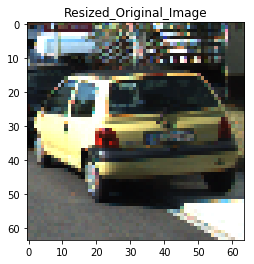

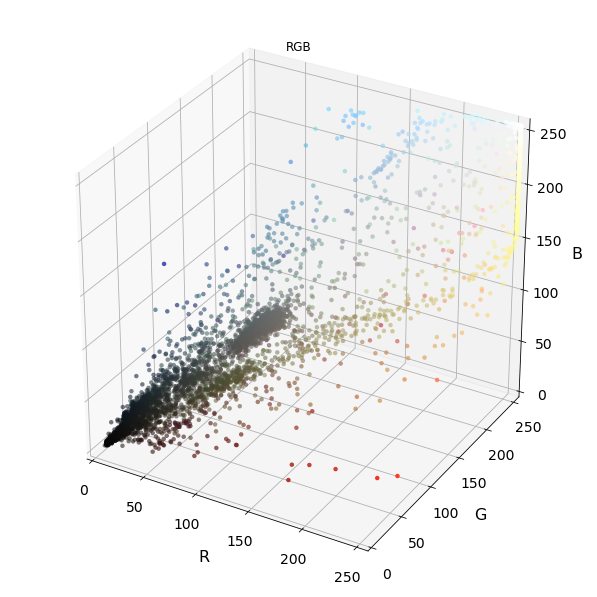

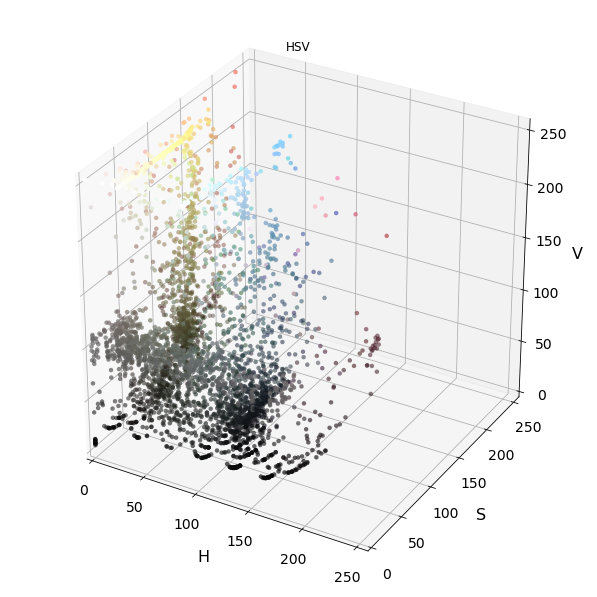

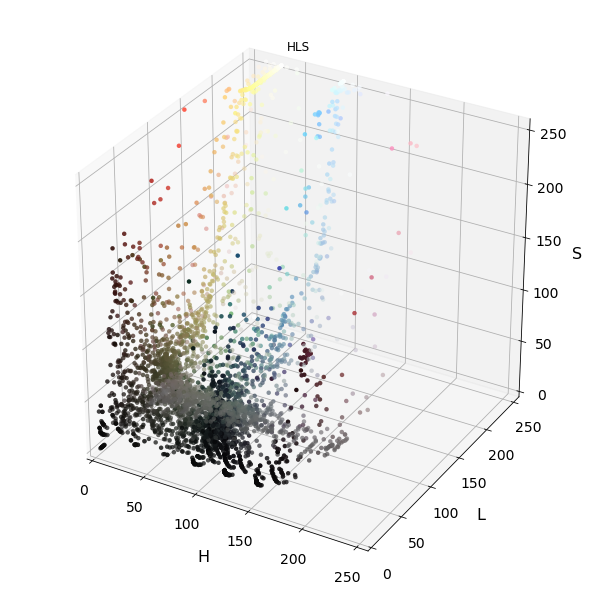

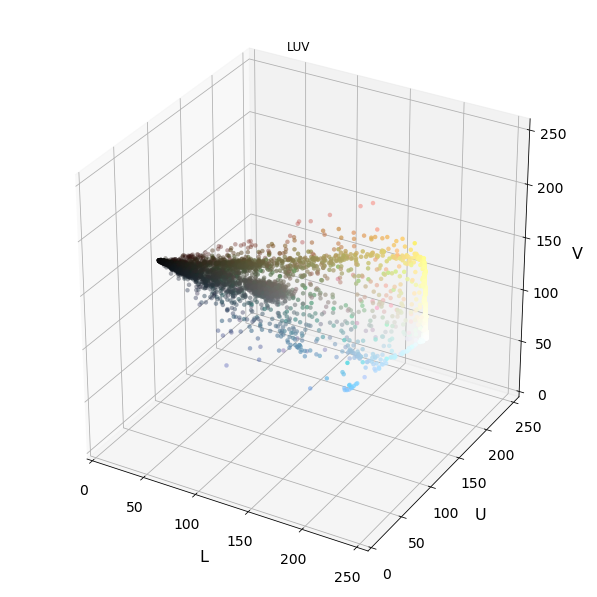

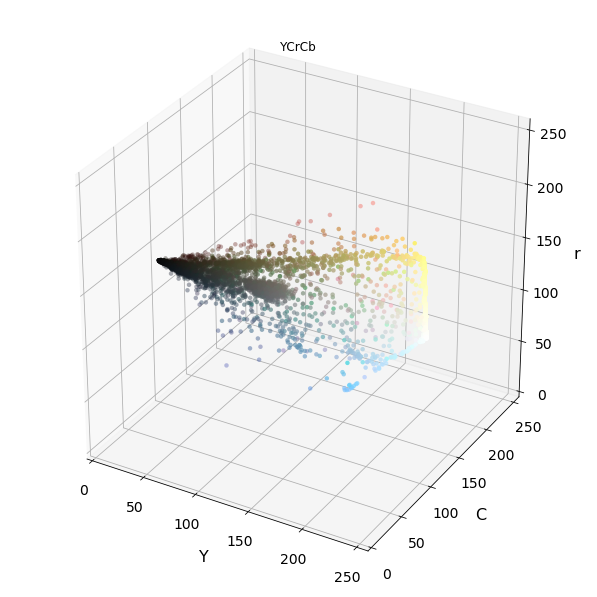

In [3]:
# Test on different color space
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax

# Read a color image
img = cv2.imread("test_images/test8.png")

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plt.figure()
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.title('Resized_Original_Image')

plot3d(img_small_RGB, img_small_rgb)
plt.title('RGB')
plt.show()


plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.title('HSV')
plt.show()


plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
plt.title('HLS')
plt.show()


plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
plt.title('LUV')
plt.show()


plot3d(img_small_LUV, img_small_rgb, axis_labels=list("YCrCb"))
plt.title('YCrCb')
plt.show()

# HLS can seperate the vehicle well.

### Spatial Binning of color

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


### Color Histogram

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### scikit-image HOG

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


### Extract Features

In [7]:
def extract_features_color(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)     
        # Resize the feature_image to the same size
        feature_image = cv2.resize(feature_image,spatial_size)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_hog(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size = (16,16)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image) 
            
        # Resize the feature_image to the same size
        feature_image = cv2.resize(feature_image,spatial_size)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

## Explore HOG features

/home/ftb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


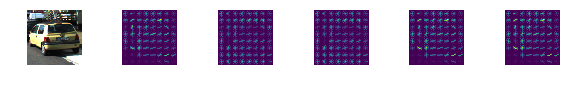

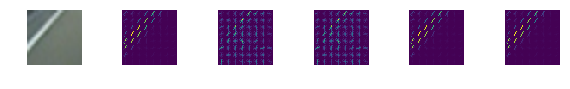

In [8]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
vis = True
feature_vec = True
def hog_image_analy(img, orient, pix_per_cell, cell_per_block, vis, feature_vec):
    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
    img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)

    features, hog_image_RGB = get_hog_features(img_small_RGB[:,:,0], orient, pix_per_cell, cell_per_block, 
                            vis, feature_vec)
    features, hog_image_HSV = get_hog_features(img_small_HSV[:,:,0], orient, pix_per_cell, cell_per_block, 
                            vis, feature_vec)
    features, hog_image_HLS = get_hog_features(img_small_HLS[:,:,0], orient, pix_per_cell, cell_per_block, 
                            vis, feature_vec)
    features, hog_image_LUV = get_hog_features(img_small_LUV[:,:,0], orient, pix_per_cell, cell_per_block, 
                            vis, feature_vec)
    features, hog_image_YCrCb = get_hog_features(img_small_YCrCb[:,:,0], orient, pix_per_cell, cell_per_block, 
                            vis, feature_vec)
    images = [img_small_RGB]
    images.append(hog_image_RGB);images.append(hog_image_HSV)
    images.append(hog_image_HLS);images.append(hog_image_LUV)
    images.append(hog_image_YCrCb)
    return images

# Car Image
images = hog_image_analy(img, orient, pix_per_cell, cell_per_block, vis, feature_vec)
count = 0
plt.figure(figsize = (10,1))
for image_hog in images:
    count += 1
    plt.subplot(1,6,count)
    plt.imshow(image_hog)
    plt.axis('off')

# Notcar Image
img_notcar = mpimg.imread('test_images/image12.png')
images = hog_image_analy(img_notcar, orient, pix_per_cell, cell_per_block, vis, feature_vec)
count = 0
plt.figure(figsize = (10,1))
for image_hog in images:
    count += 1
    plt.subplot(1,6,count)
    plt.imshow(image_hog)
    plt.axis('off')


### Read the image file names in image_vault

In [9]:
# Image filenames input
images_V_GTF_F = glob.glob('image_vault/vehicles/GTI_Far/*.png')
images_V_GTF_L = glob.glob('image_vault/vehicles/GTI_Left/*.png')
images_V_GTF_M = glob.glob('image_vault/vehicles/GTI_Middleclose/*.png')
images_V_GTF_R = glob.glob('image_vault/vehicles/GTI_Right/*.png')
images_V_KITTI_E = glob.glob('image_vault/vehicles/KITTI_extracted/*.png')

images_NV_GTI = glob.glob('image_vault/non-vehicles/GTI/*.png')
images_NV_Extr = glob.glob('image_vault/non-vehicles/Extras/*.png')

cars = images_V_GTF_F+images_V_GTF_L+images_V_GTF_M+images_V_GTF_R+images_V_KITTI_E
notcars = images_NV_GTI + images_NV_Extr

print('There are '+str(len(cars))+' car images in the data set.')
print('There are '+str(len(notcars))+' notcar images in the data set.')

#Check whether the data is balanced
if abs(len(cars)-len(notcars)) < int((len(cars)+len(notcars))*0.05):
    print('The dataset is balanced')
else:
    print('The dataset is not balanced')

There are 8373 car images in the data set.
There are 8968 notcar images in the data set.
The dataset is balanced


### SVM training Pipeline (Image Read, shuffle, and normalization)

In [10]:

# Reduced the amount of image in the dataset to speed up dubugging

## sample_size = 500
## cars = cars[0:sample_size]
## notcars = notcars[0:sample_size]

# TODO play with these values to see how your classifier
# performs under different binning scenarios

# After experiment, the following parameters compose the best set for the test_score accuracy
color_space = 'HLS'
spatial = 16
histbin = 48
spatial_size = (spatial,spatial)

car_features_color = extract_features_color(cars, cspace=color_space, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features_color = extract_features_color(notcars, cspace=color_space, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
color_space_hog = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features_hog = extract_features_hog(cars, cspace=color_space_hog, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = spatial_size)
notcar_features_hog = extract_features_hog(notcars, cspace=color_space_hog, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = spatial_size)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# concatenate the hog and color features for each image
car_features = []
notcar_features = []

for i in range(len(car_features_hog)):
    car_features.append(np.concatenate((car_features_color[i],car_features_hog[i])))
for i in range(len(notcar_features_hog)):
    notcar_features.append(np.concatenate((notcar_features_color[i],notcar_features_hog[i])))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

## sys.exit("Error message")
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state, shuffle = True)

from sklearn.externals import joblib
# joblib.dump(clf, 'trained_svm.pkl')
clf = joblib.load('trained_svm.pkl')

# # Use a GridSearchCV to find the best SVM parameters
# parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,0.5,1]}
# svr = svm.SVC()
# clf = grid_search.GridSearchCV(svr, parameters)
# t = time.time()
# clf.fit(X_train, y_train)
# t2 = time.time()
# print('There are '+str(y_train.shape[0])+' training data')
# print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()
n_predict = 10
print('The SVM Hyperparameters used are: '+'C = '+str(clf.best_params_['C'])+' ,kernel = '+str(clf.best_params_['kernel']))
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/home/ftb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


17.67 Seconds to extract HOG features...
Test Accuracy of SVC =  0.9974
The SVM Hyperparameters used are: C = 1 ,kernel = rbf
My SVC predicts:  [ 0.  1.  1.  0.  0.  1.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  1.  1.  1.  0.  1.]
27.48193 Seconds to predict 10 labels with SVC


### Save the trained SVM model

In [11]:
# from sklearn.externals import joblib
# joblib.dump(clf, 'trained_svm.pkl')
# clf = joblib.load('trained_svm.pkl')

### Sliding window


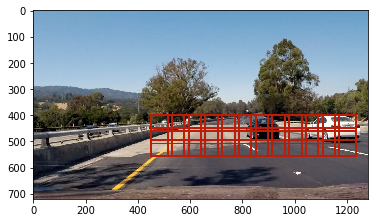

In [12]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((x_span-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((y_span-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
image = mpimg.imread('test_images/test4.jpg')
# An example of sliding window
windows1 = slide_window(image, x_start_stop=[400, None], y_start_stop=[400, 600], 
                    xy_window=(120, 95), xy_overlap=(0.3, 0.3))

windows2 = slide_window(image, x_start_stop=[450, None], y_start_stop=[400, 600], 
                    xy_window=(100, 70), xy_overlap=(0.3, 0.3))

windows3 = slide_window(image, x_start_stop=[380, None], y_start_stop=[380, 650], 
                    xy_window=(140, 85), xy_overlap=(0.4, 0.4))  

windows4 = slide_window(image, x_start_stop=[365, None], y_start_stop=[400, 650], 
                    xy_window=(180, 120), xy_overlap=(0.5, 0.5))  

windows5 = slide_window(image, x_start_stop=[350, None], y_start_stop=[400, 680], 
                    xy_window=(300, 240), xy_overlap=(0.7, 0.7))

windows6 = slide_window(image, x_start_stop=[450, None], y_start_stop=[400, 600], 
                    xy_window=(80, 60), xy_overlap=(0.2, 0.2))

windows_collect = []
windows = []
windows_collect.append(windows1);windows_collect.append(windows2);windows_collect.append(windows3);
windows_collect.append(windows4);windows_collect.append(windows5);windows_collect.append(windows6)
window_img = np.copy(image)
color_map = [[0,0,255],[0,255,0],[255,0,0],[50,136,213],[85,14,90],[185,30,10]]
for i in range(len(windows_collect)):
    ind = 5
    window_img = draw_boxes(window_img, windows_collect[ind], color=color_map[ind], thick=6)      
    windows += windows_collect[i]
plt.imshow(window_img)


### Single Image Feature Extraction

In [13]:
def single_img_features(img, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=48, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    feature_image_hog = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image_hog.shape[2]):
                hog_features.extend(get_hog_features(feature_image_hog[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image_hog[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


### Search the sliding windows in the image

In [14]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='HLS', 
                    spatial_size=(16, 16), hist_bins=48, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], spatial_size)
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        ## sys.exit('Error Message')
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(features.reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


### Vehicle Tracking Example

/home/ftb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


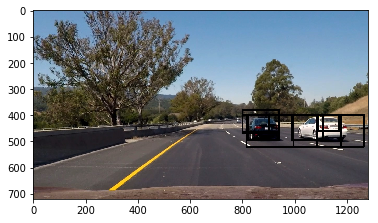

In [15]:
image_name = 'test6.jpg'
image_test = mpimg.imread('test_images/'+image_name)
# Rescale the jpg image to png image
image_test = np.float32(image_test)/255.0
spatial_feat = True
hist_feat = True
hog_feat = True
hot_windows = search_windows(image_test, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=(16,16), hist_bins=48, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel='ALL', spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(image_test, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Deal with false positives and duplicates

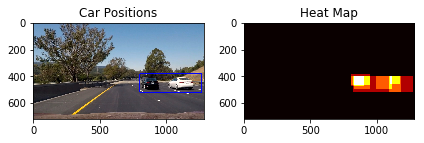

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
## Example
image_heat = mpimg.imread('test_images/'+image_name)
heat = np.zeros_like(image_heat[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image_heat), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


### Draw the bounding box

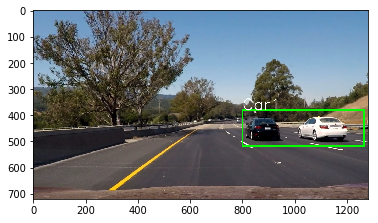

In [17]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        color = [[0,0,255],[0,255,0],[255,0,0],[50,136,213],[85,14,90]]
        cv2.rectangle(img, bbox[0], bbox[1], color[car_number], 6)
        cv2.putText(img,'Car'+str(car_number),bbox[0], 
                    cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2,cv2.LINE_AA)
    # Return the image
    return img

# Read in the last image above
image = mpimg.imread('test_images/'+image_name)
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.imshow(draw_img)

### Subsmaple hog features

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

### Video Pipeline

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
class video_frames(object):
    def __init__(self):
        self.heatmap_per_f = []
        self.detected_vehicle = []
        self.vehicle_lock = []
car_video = video_frames()
def pipeline(img, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=(16,16), hist_bins=48, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat):
    process_img = np.copy(img)
    # Rescale the jpg image to png image
    image = np.float32(process_img)/255.0
    spatial_feat = True
    hist_feat = True
    hog_feat = True
    
    # Find the windows containing the vehicle
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=(16,16), hist_bins=48, 
                            orient=9, pix_per_cell=8, 
                            cell_per_block=2, 
                            hog_channel='ALL', spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)  
    
    # Remove false positives and duplicates
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    if len(car_video.heatmap_per_f) < 10:
        car_video.heatmap_per_f.append(heat)
    else:
        car_video.heatmap_per_f.pop(0)
        car_video.heatmap_per_f.append(heat)
    
    heat_sum = np.zeros_like(img[:,:,0]).astype(np.float)
    
    for i in range(len(car_video.heatmap_per_f)):
        heat_sum += car_video.heatmap_per_f[i]
        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat_sum,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(img, labels)
   ## draw_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
    return draw_img
output = 'output_videos/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")

## output = 'output_videos/video_output_test.mp4'
## clip1 = VideoFileClip("test_video.mp4")
clip = clip1.fl_image(lambda img: pipeline(img, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=(16,16), hist_bins=48, 
                        orient=9, pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat))
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [14:54<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 14min 49s, sys: 2.98 s, total: 14min 52s
Wall time: 14min 55s


In [20]:
# clip.ipython_display(width = 400)